# The aim of the project: Predicting the overall rating of Amazon Kindle products based on the textual content of the reviews.

* Applicant's Name: Michael Sun
* Position Applied For: Intern Data Scientist
* Documentations at the end.

## First, Based on the basic observation of the dataset and the purpose of our project, we are interested in the two  variables which are reviewText and overall. We assume that Review id, asin, review name, summary, helpful, and time have no impact on the overall rate. The feature that most directly affects the rate should be reviewText, so only reviewText is selected as input.

In [2]:
import pandas as pd

# We select reviewText and overall for the aim of the project.
# load the dataset
df = pd.read_csv('review_Kindle_Store.csv', usecols=['reviewText', 'overall'])

# Display the first few rows of data.
print(df.head())

                                          reviewText  overall
0  I enjoy vintage books and movies so I enjoyed ...      5.0
1  This book is a reissue of an old one; the auth...      4.0
2  This was a fairly interesting read.  It had ol...      4.0
3  I'd never read any of the Amy Brewster mysteri...      5.0
4  If you like period pieces - clothing, lingo, y...      4.0


In [3]:
# Convert the data into the list 
# 1. Flexibility: Sometimes converting data to a list allows for more flexibility in performing certain types of operations.
# 2. Memory usage: For small datasets, lists may be more memory efficient because pandas DataFrames have additional metadata overhead.
# we can use pandas as well: More efficient data operation for larger dataset. 
# 1. Reduce the amount of code. more powerful functins can perform complex data analysis. 
# 2. Come with it's own index more convienient for data operation.

# Next, we need to convert each review text into a word vector.
review_text_list = list(df["reviewText"])
rate_list = list(df["overall"])

# Check the total amount of data
print(len(review_text_list))
print(len(rate_list)) 

982619
982619


In [6]:
# Initialize lists to store text length, filtered text, and ratings
# Handling dirty data. Pandas is more efficient.
text_length_list = []
rate_filter_list = []
text_filter_list = []

# Traverse all text, calculate length and filter invalid data
for i in range(len(review_text_list)):
    text = review_text_list[i]
    rate = rate_list[i]
    try:
        text_length_list.append(len(text.split())) # Calculate the length of each text in reviewText
        text_filter_list.append(text) # Add to the filtered text list
        rate_filter_list.append(rate) # Add to the filtered rating list
    # If an exception occurs, the data will not be included in the training.
    # check null value and filter out
    except Exception as e:
        pass
        #print(text)

# Because the local CPU is used for running, running all the data is too slow.
# Use 300,000 data points for training
data_num = 300000 

text_length_list = text_length_list[:data_num] #The length of the text in revewTxet, not the length of the words.
rate_filter_list = rate_filter_list[:data_num]
text_filter_list = text_filter_list[:data_num]
# print(text_length_list)

In [7]:
# Check the average length of the text. To run well on this data, we better choose a long text model, such as transformer.
# Estimated number of words
average_length = sum(text_length_list) / len(text_length_list)
print("total text length : ", len(text_length_list))

# Word length and text length are considered. The average text and word are too long. Word vectors are based on words. 
# The first 25 words are taken forcibly.
# Identify texts longer than the average length
long_strings = [s for s in text_length_list if s > average_length]
print("the average length:", average_length)
print("the length longer than average text number : ", len(long_strings))

total text length :  300000
the average length: 105.18865333333333
the length longer than average text number :  90771


In [5]:
import os
import hashlib

# Windows does not support it, you need to download and decompress it manually.
def file_hash(filename):
    """Calculate the MD5 hash of a file"""
    hash_md5 = hashlib.md5()
    with open(filename, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

file_name = 'glove.6B.zip'
url = 'https://nlp.stanford.edu/data/glove.6B.zip'

# glove.6B.zip correct MD5 hash value： Global Vectors for Word Representation
correct_hash = '056ea991adb4740ac6bf1b6d9b50408b'

# Words become numbers, using the glove dictionary, inputting a word will return a number.
# 500 words, words are related to each other. So words become phase quantities in space. Connected in space.
# What are the training word vector models? GloVe, word2vec, Skip-gram and CBOW

# Check if glove.6B.zip have been alreday downloaded.
if os.path.exists(file_name) and file_hash(file_name) == correct_hash:
    print("File exists and hash matches. No need to download.")
else:
    print("downloading...")
    !curl -o {file_name} {url} -L
    !unzip {file_name}

File exists and hash matches. No need to download.


In [8]:
import numpy as np
# Load the glove dictionary. embedding turns words into vectors and embeds them into an N-dimensional space.
# Word embedding is to map the words in the space X to a multi-dimensional vector in the space Y. 
# Then the multi-dimensional vector is equivalent to embedding in the space Y. One carrot one pit. 
# Word embedding is to find a mapping or function to generate an expression in a new space. The expression is the word representation.
# Word embeddings are a way of representing words as vectors in a multi-dimensional space, where the distance and direction between vectors reflect the similarity and relationships among the corresponding words.

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index
    
# Adv of Glove: Globally optiminzing the co-occurrence matrix.
# Interpretability: good geometric structure in vector space.
# Adaptablilty： handle large-scale corpora and generate high-quality word vector representations.
# Use 6B 100d, which is more suitable for local CPU operation.
# Load word vectors into embeddings_index dictionary
embeddings_index = load_glove_embeddings('glove.6B/glove.6B.100d.txt')

In [9]:
# Convert sentences into matrices
def sentence_to_vec(sentence, embeddings_index, max_len=50, vec_size=100):
    words = sentence.split()
    sentence_matrix = np.zeros((max_len, vec_size))

    for i, word in enumerate(words):
        if i >= max_len:
            break
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_matrix[i] = vector
        else:
            sentence_matrix[i] = np.random.normal(size=(vec_size,))

    return sentence_matrix

# Demo checking
sentence = "This is an example sentence hello"
vec_matrix = sentence_to_vec(sentence, embeddings_index)
print(vec_matrix.shape)

(50, 100)


In [10]:
# Locally use CPU training, so using 25 as the text length. If we use GPU, we can try to modify it to a longer time step, LSTM can also support it, https://stats.stackexchange.com/questions/295106/sequence-lengths-in-lstm-bilstms-and-overfitting
# Embedded in a 25*100 vector

text_length = 25 

# Allocate all memory to speed up training and avoid temporary memory allocation during training
# np.zeros gets the matrix out and adds the data in
X_data = np.zeros((len(text_filter_list), int(text_length), 100))
# Put X_data into a 300000*25*100 vector
for i in range(len(text_filter_list)):
    X_data[i] = sentence_to_vec(text_filter_list[i], embeddings_index, int(text_length), 100)

In [11]:
# Convert ratings into vectors
# 300000*1
y_data = np.array(rate_filter_list).astype(np.int64) 

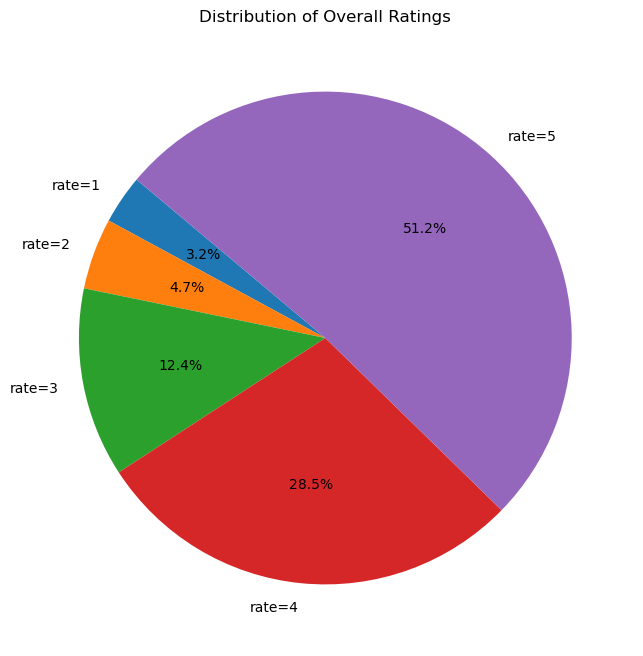

In [12]:
import matplotlib.pyplot as plt
# View the proportion of Overall Rating.
label_num = [np.count_nonzero(y_data == 1), # How many of select data (200000) are rate 1?
             np.count_nonzero(y_data == 2),
             np.count_nonzero(y_data == 3), 
             np.count_nonzero(y_data == 4), 
             np.count_nonzero(y_data == 5)]

plt.figure(figsize=(8, 8))  
plt.pie(label_num, labels=["rate=1","rate=2","rate=3","rate=4","rate=5"], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.show()

From the distribution of the overall rate, we can see that about 50% of the ratings are 5, and about 30% of the ratings are 4. There is a sample imbalance problem.

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# X_data: an array of shape (n_samples, max_len, vec_size)
# y_data: an array of shape (n_samples)
X_data = torch.tensor(X_data, dtype=torch.float32)  # # Convert numpy to PyTorch tensor
y_data = torch.tensor(y_data, dtype=torch.int64) # # Convert to PyTorch tensor
print(X_data.shape, y_data.shape)

# training and test dataset split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=20)

# From the pie chart above, we can see that this is a sample imbalance problem, so we use WeightedRandomSampler to balance the sample. 
# This sampler will sample from the data according to the weight.
# Imbalanced data preprocessing
class_counts = [np.count_nonzero(y_train == 1), 
                np.count_nonzero(y_train == 2),
                np.count_nonzero(y_train == 3), 
                np.count_nonzero(y_train == 4), 
                np.count_nonzero(y_train == 5)]


print(class_counts, sum(class_counts))
total_count = sum(class_counts)
print(total_count)

class_weights = [total_count / c  for c in class_counts]
# Sampling weight: Sample weight is derived from the rate percentage
sample_weights = [class_weights[y - 1] for y in y_train] # Setting sample weights
print(total_count)
sampler = WeightedRandomSampler(sample_weights, num_samples=total_count, replacement=True)

# one-hot encoding the data. The one hot index starts at 0 and the data labels are from 1 to 5, so -1 is needed.
y_train = y_train - 1
y_test = y_test - 1
y_train = F.one_hot(y_train, num_classes=5).float()
y_test = F.one_hot(y_test, num_classes=5).float()
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader
# The train data uses the sampler sampler and does not need to be shuffled.
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
# Test set does not use sampler.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

C:\Users\cuist\AppData\Local\Temp\ipykernel_22864\3757986278.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_data = torch.tensor(X_data, dtype=torch.float32)  # # Convert numpy to PyTorch tensor
C:\Users\cuist\AppData\Local\Temp\ipykernel_22864\3757986278.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.int64) # # Convert to PyTorch tensor


torch.Size([300000, 25, 100]) torch.Size([300000])
[7720, 11237, 29726, 68372, 122945] 240000
240000
240000


The output confirms that the data has been correctly converted, split, and balanced using the WeightedRandomSampler. The class counts indicate an imbalanced dataset, which has been addressed by the calculated class weights and the sampler.

In [15]:
y_train.shape

torch.Size([240000, 5])

###### The output meaning there are 240,000 training samples, each represented by a one-hot encoded vector of size 5.

In [16]:
# Check if the mini-batch samples are balanced.
for data, labels in train_loader:
    print("Batch labels distribution:")
    print(labels)
    break

Batch labels distribution:
tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.]])


In [17]:
import torch.nn as nn

# Define the text classifier model LSTM 
class SelfModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=5):
        super(SelfModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        # out = self.dropout(hidden[-1])
        out = self.fc(hidden[-1])
        return out


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SelfModel(100, 64, 5)
model.to(device)
# start training
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.max(1)[1]) 
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)# Optimizer Adam is the most used. An upgraded version of gradient descent

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10) 

Epoch 1, Loss: 1.428884506225586
Epoch 2, Loss: 1.645249843597412
Epoch 3, Loss: 1.2424613237380981
Epoch 4, Loss: 1.255494475364685
Epoch 5, Loss: 1.2915291786193848
Epoch 6, Loss: 1.5500154495239258
Epoch 7, Loss: 1.3679596185684204
Epoch 8, Loss: 1.1154717206954956
Epoch 9, Loss: 1.2705068588256836
Epoch 10, Loss: 1.2753342390060425


Precision: 30.76%
Recall: 37.01%
F1-Score: 30.96%
Accuracy: 42.13%


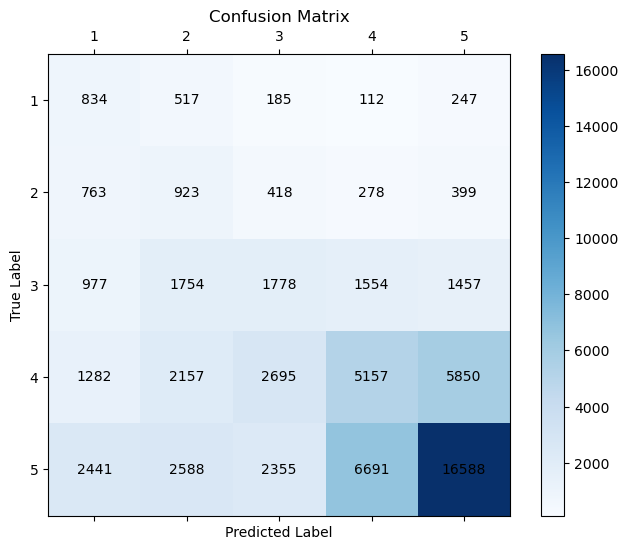

In [21]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Evaluate model performance
def evaluate_model(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_labels = []
    all_preds = []
  
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            _, true = torch.max(labels, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true.cpu().numpy())
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    precision, recall, fscore, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix) * 100  # Calculate accuracy
    #print(conf_matrix)
    
    # Print metrics
    print(f'Precision: {precision*100:.2f}%') # Among all the data predicted as TP and FP, what percentage of them are actually Positive
    print(f'Recall: {recall*100:.2f}%') # Among all the data predict as TP and FN, the percentage of them are actually Positive
    print(f'F1-Score: {fscore*100:.2f}%') # Combine the Precision and Recall
    print(f'Accuracy: {accuracy:.2f}%')  # Display accuracy

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='black')
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticks(range(len(conf_matrix)))
    ax.set_yticks(range(len(conf_matrix)))
    ax.set_xticklabels(range(1, 6))
    ax.set_yticklabels(range(1, 6))
    ax.set_title('Confusion Matrix')
    plt.show()

evaluate_model(model, test_loader) # Call the evaluation function

### Evaluating the quality of the model
1. From the accuracy score, the model is not very effective, the accuracy is below 50%, because the model is small, the text length is short, only a part of the data is used, and the number of training times is not large, so the effect is acceptable.
2. From the confusion matrix, 1 means rate 1 and so on, we can see that rate 5 is the most correctly classified as rate 5, and many rate 4 reviews are also incorrectly classified as rate 5.
3. If better machines are available, we can increase the number of training times and sample sizes as well as longer texts to improve model capabilities.

## Documentation for Amazon Kindle Reviews Analysis
1. Business Understanding
* 1.1 Objective:
    To predict the overall rating of Amazon Kindle products based on user review text.
* 1.2 Goals:
    Develop a machine learning model to classify review ratings.
    Provide insights into model performance using appropriate metrics and visualizations.

2. Data Understanding
* 2.1 Dataset:
    Sample of 982,619 reviews from the Amazon Kindle store.
    Key columns: reviewerID, asin, reviewerName, helpful, reviewText, overall, summary, unixReviewTime, reviewTime.

3. Data Preparation
* 3.1 Data Filtering:
    Review texts and ratings are extracted into separate lists.
    The length of each review text is calculated, and only valid data is kept.
    A subset of 200,000 samples is used for training due to computational constraints.
* 3.2 Text Length Analysis:
    The average length of review texts is calculated.
    Reviews longer than the average are identified.

4. Pre-trained Word Embeddings
* 4.1 GloVe Embeddings:
    GloVe embeddings are used for word representation.
    The file glove.6B.zip is downloaded and extracted if not already present.
    The embeddings are loaded into memory for further processing.

5. Model Training
* 5.1 Model Architecture:
    A deep learning model is constructed using PyTorch, specifically an LSTM for text classification.
* 5.2 Training:
    The model is trained using a training dataset for a specified number of epochs.
6. Model Evaluation
* 6.1 Evaluation Metrics:
    The model is evaluated using metrics such as precision, recall, F1-score, and accuracy.
* 6.2 Results:
    The model achieved the accuracy is below 50%, indicating potential for improvement with more training data, longer texts, and more training epochs.

7. Conclusion：
The project successfully implemented a text classification model to predict overall ratings from review texts. Future improvements could include utilizing more computational resources and advanced models for better performance.
